In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('\n')
print(device_lib.list_local_devices())

Num GPUs Available:  1


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13360959838446750392
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40282292224
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18343567769408570995
physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0"
xla_global_id: 416903419
]


2021-11-26 17:22:28.021679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 17:22:28.022296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 17:22:28.022782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 17:22:28.023339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-26 17:22:28.023831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 10)                170       
                                                                 
Total params: 53,018
Trainable params: 53,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
657/657 [==============================] - 2s 3ms/step - loss: 1.4133 - accuracy: 0.5602 - val_loss: 0.6337 - val_accuracy: 0.8312
Epoch 2/5
657/657 [======================

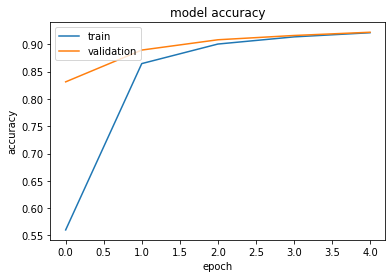

Training the model took 8.44801498693414


In [7]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.np_utils import to_categorical
from functools import reduce
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping

hidden_layer_list = [64, 32, 16] # This list is read from the settings file
input_size = 28*28
output_size = 10

dev = '/device:GPU:0'
# dev = '/cpu:0'

def data_loading(output):
  with tf.device(dev):
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    # Data preprocessing: I have to rescale and flatten all the images
    shape = (28, 28)
    shape_l = reduce(lambda a, b: a*b, shape)
    x_train = x_train.reshape((-1, shape_l)) / 255.
    x_test  = x_test.reshape((-1, shape_l)) / 255.
    # One-hot encoding
    y_train = to_categorical(y_train, num_classes = output)
    y_test  = to_categorical(y_test, num_classes = output)
    return (x_train, y_train), (x_test, y_test)

def model_def(hidden_layer, input, output): # hidden_layer is a list containing the number of neurons for each hidden layer
  with tf.device(dev):
    model = Sequential()
    for i in range(len(hidden_layer)+1):
      if i == 0:
        model.add(Dense(hidden_layer[i], activation='relu', input_shape=(input_size,)))
      elif i == len(hidden_layer):
        model.add(Dense(output_size, activation='softmax'))
      else:
        model.add(Dense(hidden_layer[i], activation='relu'))

    loss = keras.losses.CategoricalCrossentropy()
    optim = keras.optimizers.SGD(learning_rate=0.01, momentum=0.05)
    metrics=["accuracy"]
    model.compile(loss=loss, optimizer=optim, metrics=metrics)
    model.summary()
    return model  

def main():
  with tf.device(dev):
    (X_train, Y_train), (X_test, Y_test) = data_loading(output_size)
    nn = model_def(hidden_layer_list, input_size, output_size)

    es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=4)

    # Time the training
    begin = timer()
    history = nn.fit(X_train, Y_train, batch_size=64, epochs=5, validation_split=0.3, shuffle=True, callbacks=es, verbose=1)
    training_time = timer() - begin

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # Time the testing


    # Report computation time
    print("Training the model took %s" % training_time)

    return 0

if __name__=="__main__":
  main()